In [1]:
!pip install -q clu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.


In [2]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

In [3]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-05-10 13:52:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2024-05-10 13:52:07 (15.8 MB/s) - 'input.txt' saved [1115394/1115394]



In [4]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = jnp.array(encode(text), dtype=jnp.int32)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

(1115394,) int32
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1 39 56 43  1 39 50 50  1 56 43 57 53 50 60 43 42  1 56 39
 58 46 43 56  1 58 53  1 42 47 43  1 58 46 39 52  1 58 53  1 44 39 51 47
 57 46 12  0  0 13 50 50 10  0 30 43 57 53 50 60 43 42  8  1 56 43 57 53
 50 60 43 42  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 18 47
 56 57 58  6  1 63 53 59  1 49 52 53 61  1 15 39 47 59 57  1 25 39 56 41
 47 59 57  1 47 57  1 41 46 47 43 44  1 43 52 43 51 63  1 58 53  1 58 46
 43  1 54 43 53 54 50 43  8  0  0 13 50 50 10  0 35 43  1 49 52 53 61  5
 58  6  1 61 43  1 49 52 53 61  5 58  8  0  0 18 47 56 57 58  1 15 47 58
 47 64 43 52 10  0 24 43 58  1 59 57  1 49 47 50 50  1 46 47 51  6  1 39
 52 42  1 61 43  5 50 50  1 46 39 

In [8]:
train_test_split = 0.9
n = int(train_test_split*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [11]:
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 64 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128
expans = 2
n_head = 4
channel_size = n_embd // n_head
n_layers = 4
dropout = 0.2
conv_k_size = 3
n_latent_dim = 16

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + 1, (block_size,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

# print('----')

# for b in range(batch_size): # batch dimension
#     for t in range(block_size): # time dimension
#         context = xb[b, :t+1]
#         target = yb[b,t]
#         print(f"when input is {context} the target: {target}")

inputs:
(128, 64)
[[ 1 63 53 ... 40 63  1]
 [43  1 52 ... 46 39 42]
 [63  1 45 ... 50  1 61]
 ...
 [46 47 41 ... 58 43  1]
 [ 1 61 43 ... 53 59  1]
 [49  1 58 ... 53 61  1]]
targets:
(128, 64)
[[63 53 59 ... 63  1 58]
 [ 1 52 43 ... 39 42  1]
 [ 1 45 53 ...  1 61 43]
 ...
 [47 41 46 ... 43  1 47]
 [61 43  5 ... 59  1 42]
 [ 1 58 46 ... 61  1 52]]


In [12]:
class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,)) # TODO, maybe use setup will be more clear
        normed = x * jax.lax.rsqrt(np.mean(np.square(x), axis=-1, keepdims=True) + self.eps)
        output = normed * weight
        return output

In [13]:
xb.shape

(128, 64)

In [14]:
class Expan_proj(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=n_embd)(x)
        return x
    
in_proj = nn.Dense(features=n_embd)
params = in_proj.init(rng_key, xb)
in_proj.apply(params, xb).shape

(128, 128)

In [15]:
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (128,), 'kernel': (64, 128)}}

# Mamba Block
Dense --> Conv1D --> Silu --> SSM --> Silu --> 

In [16]:
class MambaBlock(nn.Module):
    
    def setup(self):          
        self.in_proj1 = nn.Dense(features=n_embd * expans)
        self.in_proj2 = nn.Dense(features=n_embd * expans)
        
        # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
        self.conv1d = nn.Conv(features=n_embd * expans,
                              kernel_size=conv_k_size,
                              padding=1,
                              )

        self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, n_embd * expans, 1))
        self.B = self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
        self.C = self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = self.param('D', jax.random.normal, (1, self.args.d_state, self.args.d_model, 1))
        self.delta = self.param('delta', jax.random.normal, (1, 1, n_embd * expans, block_size))
        
        self.out_proj = nn.Dense(n_embd)
        
        self.rms_norm = nn.RMSNorm()
        
    def __call__(self, x):
        
        embeds = x
        x = self.in_proj1(embeds)
        x = self.conv1d(x)
        x = jax.nn.silu(x)
        x = x.reshape((x.shape[0],1,x.shape[2],x.shape[1]))
        x = self.ssm(x)[1]
        x = x.reshape((x.shape[0],x.shape[3],x.shape[2]))
        x = x*jax.nn.silu(self.in_proj2(embeds))

        x = self.out_proj(x)
        
        x = self.rms_norm(x)
        
        return x
    def discretize(self):
        da = self.delta * self.A
        a_ = jnp.exp(da)
        b_ = self.C * self.delta
        return a_, b_

    def ssm(self, x):
        y = []
        h = 0
        a_, b_ = self.discretize()
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
            y.append((self.C[..., k] * h).sum(1, keepdims=True))
        return h, jnp.stack(y, -1)

In [17]:
# model = MambaBlock()
# params = model.init(jax.random.key(0), xb)
# print(model.tabulate(jax.random.key(0), xb,
#                    compute_flops=True, compute_vjp_flops=True))
# xs = model.apply(params, xb)
# xb.shape, xs.shape

In [18]:
class Mamba(nn.Module):
    
    def setup(self):
        self.embeddings = nn.Embed(vocab_size, n_embd)
        
        self.mamba_layers = [MambaBlock() for _ in range(n_layers)]
        
    def __call__(self, x):
        x = self.embeddings(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
            
        out = self.embeddings.attend(x)
        return out
    
    @jax.jit
    def generate(self, idx, max_new_tokens, params):
    # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self.apply(params, idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            ##probs = tf.keras.activations.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = jax.random.categorical(jax.random.PRNGKey(52), logits) # (B, 1)
            # append sampled index to the running sequence
            idx = jax.numpy.expand_dims(jnp.concatenate([idx[0], idx_next], axis=0), 0) # (B, T+1)
    #         print(idx_next)
    #         print(idx)

        return idx    

In [19]:
class NanoLM(nn.Module):
    """NanoLM model."""
    vocab_size: int = 65
    num_layers: int = 6
    num_heads: int = 8
    head_size: int = 32
    dropout_rate: float = 0.2
    embed_size: int = 256
    block_size: int = 64

    @nn.compact
    def __call__(self, x, training: bool):
        seq_len = x.shape[1]

        x = nn.Embed(self.vocab_size, self.embed_size)(x) + nn.Embed(
            self.block_size, self.embed_size
        )(jnp.arange(seq_len))
        for _ in range(self.num_layers):
            x_norm = nn.LayerNorm()(x)
            x = x + nn.MultiHeadDotProductAttention(
              num_heads=self.num_heads,
              qkv_features=self.head_size,
              out_features=self.head_size * self.num_heads,
              dropout_rate=self.dropout_rate,
            )(
              x_norm,
              x_norm,
              mask=jnp.tril(jnp.ones((x.shape[-2], x.shape[-2]))),
              deterministic=not training,
            )

            x = x + nn.Sequential([
              nn.Dense(4 * self.embed_size),
              nn.relu,
              nn.Dropout(self.dropout_rate, deterministic=not training),
              nn.Dense(self.embed_size),
            ])(nn.LayerNorm()(x))

        x = nn.LayerNorm()(x)
        return nn.Dense(self.vocab_size)(x)

In [23]:
key = jax.random.key(42)

# fin_model = Mamba()
# fin_params = fin_model.init(jax.random.key(42), xb)

fin_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

fin_params = fin_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(fin_params))
print(f"Total number of parameters: {n_params:_}")
# print(fin_model.tabulate(jax.random.key(42), xb,
#                    compute_flops=True, compute_vjp_flops=True))
xf = fin_model.apply(fin_params, xb, training=False)
xb.shape, xf.shape

Total number of parameters: 2_289_089


((128, 64), (128, 64, 65))

In [24]:
# token_gen = generate(jnp.zeros((1,1)).astype(jnp.int32), 100, fin_model, fin_params)
# print(token_gen)
# print(decode(token_gen[0].tolist()))

In [25]:
jax.random.categorical(jax.random.PRNGKey(5332), 1000.0*xf[1][-1][:])

Array(18, dtype=int32)

In [60]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

In [66]:
class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate, train_shape):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones(train_shape).astype(jnp.int32), training=False)['params'] # initialize parameters by passing a template image
    tx = optax.adamw(learning_rate)
    return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty(),
    )

In [67]:
@jax.jit
def train_step(state, inputs, targets, key):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, inputs, training=True, rngs={"dropout": key})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [68]:
@jax.jit
def compute_metrics(*, state, inputs, targets):
    logits = state.apply_fn({'params': state.params}, inputs, training=False)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=targets).mean()
    metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=targets, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [69]:
num_epochs = 10
learning_rate = 0.005
init_rng = jax.random.key(0)

In [70]:
state = create_train_state(fin_model, init_rng, learning_rate, train_shape)
del init_rng  # Must not be used anymore.

In [71]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [72]:
SEED = 442
key = jax.random.PRNGKey(SEED)
for step in tqdm(range(max_iters)): # increase number of steps for good results... 
    
      # sample a batch of data
    xb, yb = get_batch(key, train_data)
    state = train_step(state, xb, yb, key)
    state = compute_metrics(state=state, inputs=xb, targets=yb)
    
    key = (jax.random.split(key)[0])
    
    if (step+1) % 100 == 0: # one training epoch has passed
        for metric,value in state.metrics.compute().items(): # compute metrics
            metrics_history[f'train_{metric}'].append(value) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        # Compute metrics on the test set after each training epoch
        test_state = state
        x_test, y_test = get_batch(key, test_data)
    #     for test_batch in test_ds.as_numpy_iterator():
        test_state = compute_metrics(state=test_state, inputs=x_test, targets=y_test)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        print(f"train epoch: {(step+1)}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
        print(f"test epoch: {(step+1) }, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")    

  2%|▏         | 107/5000 [00:20<05:46, 14.13it/s] 

train epoch: 100, loss: 3.212780475616455, accuracy: 16.7052001953125
test epoch: 100, loss: 2.702373504638672, accuracy: 24.0234375


  4%|▍         | 207/5000 [00:27<04:42, 16.96it/s]

train epoch: 200, loss: 2.549715757369995, accuracy: 26.747802734375
test epoch: 200, loss: 2.4704463481903076, accuracy: 28.33251953125


  6%|▌         | 307/5000 [00:34<04:44, 16.47it/s]

train epoch: 300, loss: 2.307215452194214, accuracy: 32.577392578125
test epoch: 300, loss: 2.273993968963623, accuracy: 33.33740234375


  8%|▊         | 407/5000 [00:40<04:39, 16.44it/s]

train epoch: 400, loss: 2.118457078933716, accuracy: 37.614013671875
test epoch: 400, loss: 2.1066713333129883, accuracy: 38.24462890625


 10%|█         | 507/5000 [00:47<04:24, 16.98it/s]

train epoch: 500, loss: 1.9670876264572144, accuracy: 41.462890625
test epoch: 500, loss: 2.036057472229004, accuracy: 39.31884765625


 12%|█▏        | 607/5000 [00:54<04:13, 17.36it/s]

train epoch: 600, loss: 1.8600044250488281, accuracy: 44.33740234375
test epoch: 600, loss: 1.982511043548584, accuracy: 42.12646484375


 14%|█▍        | 707/5000 [01:00<04:02, 17.70it/s]

train epoch: 700, loss: 1.7914437055587769, accuracy: 46.01904296875
test epoch: 700, loss: 1.9236910343170166, accuracy: 42.96875


 16%|█▌        | 807/5000 [01:06<03:50, 18.17it/s]

train epoch: 800, loss: 1.7412519454956055, accuracy: 47.298828125
test epoch: 800, loss: 1.8758752346038818, accuracy: 43.9208984375


 18%|█▊        | 907/5000 [01:12<03:43, 18.29it/s]

train epoch: 900, loss: 1.7043638229370117, accuracy: 48.313350677490234
test epoch: 900, loss: 1.8695225715637207, accuracy: 43.896484375


 20%|██        | 1007/5000 [01:18<03:36, 18.43it/s]

train epoch: 1000, loss: 1.6739128828048706, accuracy: 49.135009765625
test epoch: 1000, loss: 1.8070811033248901, accuracy: 45.69091796875


 22%|██▏       | 1107/5000 [01:25<03:30, 18.50it/s]

train epoch: 1100, loss: 1.6469663381576538, accuracy: 49.757568359375
test epoch: 1100, loss: 1.8242840766906738, accuracy: 45.64208984375


 24%|██▍       | 1207/5000 [01:31<03:26, 18.38it/s]

train epoch: 1200, loss: 1.6302813291549683, accuracy: 50.154052734375
test epoch: 1200, loss: 1.8624207973480225, accuracy: 44.4580078125


 26%|██▌       | 1307/5000 [01:37<03:23, 18.10it/s]

train epoch: 1300, loss: 1.6119970083236694, accuracy: 50.6756591796875
test epoch: 1300, loss: 1.786597728729248, accuracy: 46.8505859375


 28%|██▊       | 1407/5000 [01:43<03:19, 17.97it/s]

train epoch: 1400, loss: 1.5932705402374268, accuracy: 51.1522216796875
test epoch: 1400, loss: 1.7984681129455566, accuracy: 47.216796875


 30%|███       | 1507/5000 [01:49<03:15, 17.90it/s]

train epoch: 1500, loss: 1.578249216079712, accuracy: 51.471435546875
test epoch: 1500, loss: 1.7977356910705566, accuracy: 47.20458984375


 32%|███▏      | 1607/5000 [01:56<03:11, 17.74it/s]

train epoch: 1600, loss: 1.5694198608398438, accuracy: 51.710205078125
test epoch: 1600, loss: 1.7056806087493896, accuracy: 49.0966796875


 34%|███▍      | 1707/5000 [02:02<03:06, 17.65it/s]

train epoch: 1700, loss: 1.5523884296417236, accuracy: 52.1097412109375
test epoch: 1700, loss: 1.7769691944122314, accuracy: 47.37548828125


 36%|███▌      | 1807/5000 [02:09<03:00, 17.65it/s]

train epoch: 1800, loss: 1.5409940481185913, accuracy: 52.4884033203125
test epoch: 1800, loss: 1.7423770427703857, accuracy: 48.08349609375


 38%|███▊      | 1907/5000 [02:15<02:54, 17.74it/s]

train epoch: 1900, loss: 1.526700735092163, accuracy: 52.781002044677734
test epoch: 1900, loss: 1.6932010650634766, accuracy: 49.51171875


 40%|████      | 2007/5000 [02:21<02:48, 17.74it/s]

train epoch: 2000, loss: 1.519387125968933, accuracy: 53.018062591552734
test epoch: 2000, loss: 1.7250044345855713, accuracy: 48.7548828125


 42%|████▏     | 2107/5000 [02:28<02:41, 17.89it/s]

train epoch: 2100, loss: 1.5050294399261475, accuracy: 53.38818359375
test epoch: 2100, loss: 1.7108855247497559, accuracy: 48.40087890625


 44%|████▍     | 2207/5000 [02:34<02:35, 18.01it/s]

train epoch: 2200, loss: 1.4970823526382446, accuracy: 53.619014739990234
test epoch: 2200, loss: 1.7140817642211914, accuracy: 48.71826171875


 46%|████▌     | 2307/5000 [02:40<02:29, 17.97it/s]

train epoch: 2300, loss: 1.4907474517822266, accuracy: 53.760128021240234
test epoch: 2300, loss: 1.6828410625457764, accuracy: 49.7802734375


 48%|████▊     | 2407/5000 [02:46<02:23, 18.08it/s]

train epoch: 2400, loss: 1.479750633239746, accuracy: 54.114376068115234
test epoch: 2400, loss: 1.6824431419372559, accuracy: 50.3662109375


 50%|█████     | 2507/5000 [02:53<02:18, 18.04it/s]

train epoch: 2500, loss: 1.470898985862732, accuracy: 54.29248046875
test epoch: 2500, loss: 1.6883656978607178, accuracy: 50.4638671875


 52%|█████▏    | 2607/5000 [02:59<02:12, 18.06it/s]

train epoch: 2600, loss: 1.4668104648590088, accuracy: 54.405517578125
test epoch: 2600, loss: 1.670164942741394, accuracy: 49.91455078125


 54%|█████▍    | 2707/5000 [03:05<02:07, 18.03it/s]

train epoch: 2700, loss: 1.4584206342697144, accuracy: 54.693965911865234
test epoch: 2700, loss: 1.63900887966156, accuracy: 51.33056640625


 56%|█████▌    | 2807/5000 [03:11<02:01, 18.02it/s]

train epoch: 2800, loss: 1.448813796043396, accuracy: 54.93603515625
test epoch: 2800, loss: 1.6677125692367554, accuracy: 51.0009765625


 58%|█████▊    | 2907/5000 [03:18<01:56, 18.02it/s]

train epoch: 2900, loss: 1.4453481435775757, accuracy: 55.002437591552734
test epoch: 2900, loss: 1.6262985467910767, accuracy: 51.0986328125


 60%|██████    | 3007/5000 [03:24<01:51, 17.94it/s]

train epoch: 3000, loss: 1.4338330030441284, accuracy: 55.3175048828125
test epoch: 3000, loss: 1.659890055656433, accuracy: 51.23291015625


 62%|██████▏   | 3107/5000 [03:30<01:45, 18.00it/s]

train epoch: 3100, loss: 1.4252597093582153, accuracy: 55.5767822265625
test epoch: 3100, loss: 1.6023063659667969, accuracy: 52.001953125


 64%|██████▍   | 3207/5000 [03:37<01:40, 17.92it/s]

train epoch: 3200, loss: 1.4187597036361694, accuracy: 55.744258880615234
test epoch: 3200, loss: 1.617335557937622, accuracy: 51.64794921875


 66%|██████▌   | 3307/5000 [03:43<01:34, 17.94it/s]

train epoch: 3300, loss: 1.41203773021698, accuracy: 55.978511810302734
test epoch: 3300, loss: 1.6246356964111328, accuracy: 51.03759765625


 68%|██████▊   | 3407/5000 [03:49<01:28, 17.93it/s]

train epoch: 3400, loss: 1.4049009084701538, accuracy: 56.127685546875
test epoch: 3400, loss: 1.6459627151489258, accuracy: 52.23388671875


 70%|███████   | 3507/5000 [03:55<01:23, 17.90it/s]

train epoch: 3500, loss: 1.4003571271896362, accuracy: 56.2464599609375
test epoch: 3500, loss: 1.5721138715744019, accuracy: 52.44140625


 72%|███████▏  | 3607/5000 [04:02<01:18, 17.82it/s]

train epoch: 3600, loss: 1.3948801755905151, accuracy: 56.354610443115234
test epoch: 3600, loss: 1.6372663974761963, accuracy: 51.7333984375


 74%|███████▍  | 3707/5000 [04:08<01:11, 17.97it/s]

train epoch: 3700, loss: 1.3913695812225342, accuracy: 56.5037841796875
test epoch: 3700, loss: 1.622654914855957, accuracy: 51.79443359375


 76%|███████▌  | 3807/5000 [04:14<01:06, 18.02it/s]

train epoch: 3800, loss: 1.381910800933838, accuracy: 56.7347412109375
test epoch: 3800, loss: 1.5917385816574097, accuracy: 52.47802734375


 78%|███████▊  | 3907/5000 [04:21<01:01, 17.83it/s]

train epoch: 3900, loss: 1.3782609701156616, accuracy: 56.869625091552734
test epoch: 3900, loss: 1.5765931606292725, accuracy: 52.64892578125


 80%|████████  | 4007/5000 [04:27<00:55, 17.92it/s]

train epoch: 4000, loss: 1.3688474893569946, accuracy: 57.0904541015625
test epoch: 4000, loss: 1.5670742988586426, accuracy: 53.4423828125


 82%|████████▏ | 4107/5000 [04:33<00:49, 17.91it/s]

train epoch: 4100, loss: 1.3667806386947632, accuracy: 57.167720794677734
test epoch: 4100, loss: 1.6249793767929077, accuracy: 52.099609375


 84%|████████▍ | 4207/5000 [04:40<00:44, 17.93it/s]

train epoch: 4200, loss: 1.3626611232757568, accuracy: 57.29443359375
test epoch: 4200, loss: 1.6148940324783325, accuracy: 52.11181640625


 86%|████████▌ | 4307/5000 [04:46<00:38, 17.97it/s]

train epoch: 4300, loss: 1.3535327911376953, accuracy: 57.520381927490234
test epoch: 4300, loss: 1.606919288635254, accuracy: 52.77099609375


 88%|████████▊ | 4407/5000 [04:52<00:32, 18.04it/s]

train epoch: 4400, loss: 1.34852135181427, accuracy: 57.720458984375
test epoch: 4400, loss: 1.5447049140930176, accuracy: 53.6865234375


 90%|█████████ | 4507/5000 [04:58<00:27, 17.95it/s]

train epoch: 4500, loss: 1.3467916250228882, accuracy: 57.805294036865234
test epoch: 4500, loss: 1.5821303129196167, accuracy: 53.11279296875


 92%|█████████▏| 4607/5000 [05:05<00:21, 17.94it/s]

train epoch: 4600, loss: 1.3447343111038208, accuracy: 57.818603515625
test epoch: 4600, loss: 1.5475398302078247, accuracy: 53.82080078125


 94%|█████████▍| 4707/5000 [05:11<00:16, 17.88it/s]

train epoch: 4700, loss: 1.3355233669281006, accuracy: 58.0660400390625
test epoch: 4700, loss: 1.556276559829712, accuracy: 53.0029296875


 96%|█████████▌| 4807/5000 [05:17<00:10, 17.93it/s]

train epoch: 4800, loss: 1.3352992534637451, accuracy: 57.9549560546875
test epoch: 4800, loss: 1.561044692993164, accuracy: 53.43017578125


 98%|█████████▊| 4907/5000 [05:24<00:05, 17.94it/s]

train epoch: 4900, loss: 1.3291606903076172, accuracy: 58.208858489990234
test epoch: 4900, loss: 1.580240249633789, accuracy: 53.8818359375


100%|██████████| 5000/5000 [05:30<00:00, 15.14it/s]

train epoch: 5000, loss: 1.3247631788253784, accuracy: 58.2939453125
test epoch: 5000, loss: 1.6193592548370361, accuracy: 52.9052734375


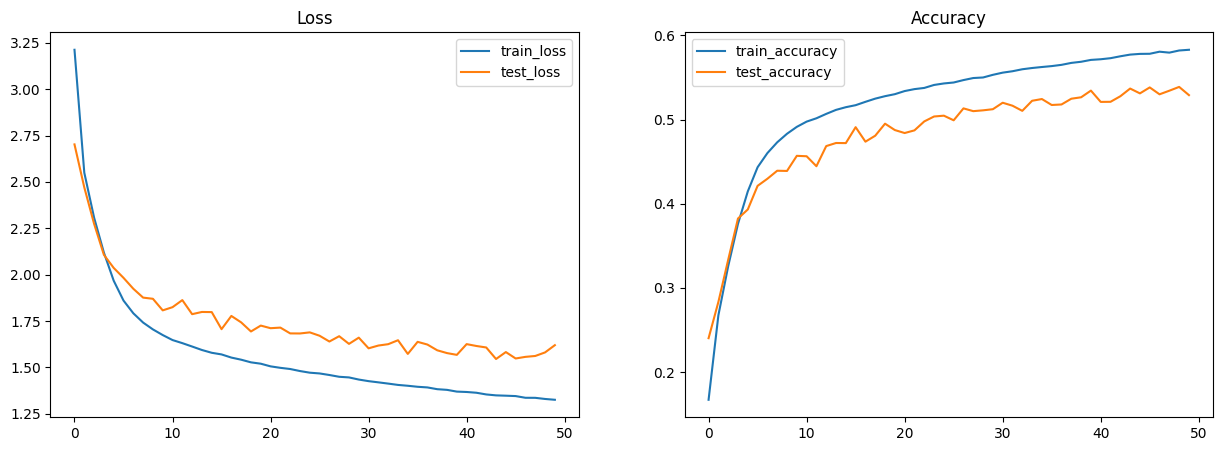

<Figure size 640x480 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [74]:

logits = fin_model.apply(fin_params, xb)
loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=yb).mean()

print(loss)

TypeError: NanoLM.__call__() missing 1 required positional argument: 'training'

In [ ]:
# def generate_text(idx, max_new_tokens, params):
# # idx is (B, T) array of indices in the current context
#     for i in range(max_new_tokens):
#         # crop idx to the last block_size tokens
#         idx_cond = idx[:, -block_size:]
#         # get the predictions
#         logits = fin_model.apply(params, idx_cond)
#         # focus only on the last time step
#         logits = logits[:, -1, :] # becomes (B, C)

#         if i == 0:
#             rng, rng_subkey = jax.random.split(jax.random.PRNGKey(12))
#         else:
#             rng, rng_subkey = jax.random.split(rng)
            
#         idx_next = jax.random.categorical(rng_subkey, logits, axis=-1, shape=(1, 1)) # (B, 1)

        
#         # append sampled index to the running sequence
#         idx = jnp.concatenate([idx, idx_next], axis=-1) # (B, T+1)

#     return idx    

In [77]:
@partial(jax.jit, static_argnames=("self", "length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits = fin_model.apply(params, context, training=False)
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits[:, -1, :], axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.zeros((1, block_size), dtype=jnp.int32)),
    (),
    length=length,
    )
    return new_tokens

/opt/conda/lib/python3.10/site-packages/jax/_src/api_util.py:231: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [78]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, {'params': state.params}, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print(decode(token_gen))

[24, 33, 15, 21, 27, 10, 0, 21, 5, 50, 50, 1, 50, 43, 58, 1, 51, 43, 1, 57, 46, 53, 59, 50, 42, 1, 46, 43, 1, 41, 53, 52, 42, 43, 51, 52, 5, 42, 1, 44, 56, 53, 51, 1, 46, 47, 57, 1, 57, 43, 60, 43, 56, 39, 58, 43, 8, 0, 0, 25, 13, 30, 21, 13, 26, 13, 10, 0, 21, 1, 56, 43, 57, 53, 50, 60, 43, 42, 1, 58, 53, 1, 58, 46, 43, 1, 52, 47, 45, 46, 58, 10, 1, 40, 39, 52, 47, 57, 46, 43, 42, 6, 1, 61, 47, 58, 46, 1, 51, 43, 6, 0, 15, 53, 51, 43, 1, 58, 46, 43, 1, 61, 46, 47, 50, 43, 1, 59, 54, 53, 52, 1, 58, 46, 43, 1, 53, 61, 52, 1, 58, 46, 47, 52, 45, 57, 1, 42, 53, 1, 51, 59, 41, 49, 1, 58, 53, 12, 0, 21, 44, 1, 63, 53, 59, 1, 51, 39, 63, 1, 54, 47, 58, 63, 1, 46, 39, 42, 1, 43, 56, 43, 1, 58, 43, 56, 51, 1, 53, 40, 43, 57, 43, 55, 59, 47, 56, 43, 0, 13, 52, 42, 1, 40, 43, 1, 58, 53, 53, 1, 45, 43, 52, 58, 50, 43, 51, 39, 52, 8, 1, 32, 46, 43, 1, 58, 47, 43, 1, 53, 56, 42, 43, 56, 1, 49, 47, 57, 57, 1, 54, 56, 53, 51, 47, 57, 43, 6, 0, 39, 42, 60, 53, 41, 46, 47, 52, 45, 6, 1, 51, 63, 1, 61, 

In [ ]:
print(decode(token_gen))

In [ ]:
att_model = NanoLM(
    vocab_size=vocab_size,
    num_layers=4,
    num_heads=8,
    head_size=32,
    dropout_rate=0.2,
    embed_size=256,
    block_size=64,
)

var_params = att_model.init(
    key,
    jnp.ones((batch_size, block_size), dtype=jnp.int32),
    training=False,
)

n_params = sum(p.size for p in jax.tree_util.tree_leaves(var_params))

print(f"Total number of parameters: {n_params:_}")

In [ ]:
jax.random.categorical(jax.random.PRNGKey(100), jnp.array([10.0,-10.0,-10.0,10.0,-11.0,-11.0,-11.0,-100.0,-1000]))

In [ ]:
logitss = state.apply_fn({'params': state.params}, (43*jnp.zeros((1,1))).astype(jnp.int32))[:,-1,:]

In [ ]:
token_gen[:,-32:]

In [ ]:
print("gen text: ",print(decode(token_gen[0].tolist())), "end of text")

In [ ]:
jax.random.randint(jax.random.PRNGKey(52), (1,32), minval, maxval

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np

logitss = state.apply_fn({'params': state.params}, xbb[0].reshape(1,32))[:,-1,:]

probs = F.softmax(torch.from_numpy(np.asarray(logitss)), dim=-1) # (B, C)
# sample from the distribution
idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
idx_next

In [ ]:
1.